## Using Generative AI to automatically create a video lecture from an article

This notebook uses Gemini to extract key points from an article and create a lecture script.

Then, it uses Text to Speech to create the audio track

And the Python library moviepy to create a movie.

For details, see:
https://medium.com/@lakshmanok/using-generative-ai-to-automatically-create-a-video-lecture-from-an-article-6381c44c5fe0

In [1]:
#%pip install --quiet --upgrade -r requirements.txt

In [2]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv("../genai_agents/keys.env")
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

## Get text of article

In [3]:
ARTICLE_URL = "https://lakshmanok.medium.com/what-goes-into-bronze-silver-and-gold-layers-of-a-medallion-data-architecture-4b6fdfb405fc"

In [4]:
import pdfkit
pdfkit.from_url(ARTICLE_URL, "article.pdf")

True

In [5]:
pdf_file = genai.upload_file("article.pdf")

## Convert to lecture notes (JSON)

In [6]:
lecture_prompt = """
You are a university professor who needs to create a lecture to
a class of undergraduate students.

* Create a 10-slide lecture based on the following article.
* Each slide should contain the following information:
  - title: a single sentence that summarizes the main point
  - key_points: a list of between 2 and 5 bullet points. Use phrases, not full sentences.
  - lecture_notes: 3-10 sentences explaining the key points in easy-to-understand language. Expand on the points using other information from the article.
* Also, create a title for the lecture and attribute the original article's author.
"""

In [7]:
from pydantic import BaseModel
from typing import List
class Slide(BaseModel):
    title: str
    key_points: List[str]
    lecture_notes: str

class Lecture(BaseModel):
    slides: List[Slide]
    lecture_title: str
    based_on_article_by: str

In [8]:
model = genai.GenerativeModel(
    "gemini-1.5-flash-001",
    system_instruction=[lecture_prompt]
)
generation_config={
    "temperature": 0.7,
    "response_mime_type": "application/json",
    "response_schema": Lecture
}
responses = model.generate_content(
    [pdf_file],
    generation_config=generation_config,
    stream=False
)

In [9]:
import json
lecture = json.loads(responses.text)

In [10]:
len(lecture['slides'])

8

In [11]:
lecture['lecture_title']

'The 4-Layer Medallion Architecture for Data Platforms'

In [12]:
lecture['slides'][2]

{'key_points': ['Silver layer cleans, structures, and prepares data for self-service analytics.',
  'Data is denormalized and organized for easier use.',
  'Type 2 slowly changing dimensions are handled in this layer.',
  'Governance responsibility lies with the source team.'],
 'lecture_notes': 'The silver layer takes data from the bronze layer and transforms it into a usable format for self-service analytics. This involves cleaning, structuring, and organizing the data. Type 2 slowly changing dimensions, which track changes over time, are also handled in this layer. The governance of the silver layer rests with the source team, which is typically the data engineering team responsible for the source system.',
 'title': 'The Silver Layer: Data Transformation and Preparation'}

In [13]:
## Write this out
with open("lecture.json", "w") as ofp:
    json.dump(lecture, ofp)

## Convert lecture.json to PowerPoint

In [14]:
import json
with open("lecture.json", "r") as ifp:
    lecture = json.load(ifp)

In [15]:
from pptx import Presentation
presentation = Presentation()

In [16]:
# Title slide for presentation
# see https://python-pptx.readthedocs.io/en/latest/user/quickstart.html
slide = presentation.slides.add_slide(presentation.slide_layouts[0])
title = slide.shapes.title
title.text = lecture['lecture_title']
subtitle = slide.placeholders[1] # subtitle
subtitle.text = f"Based on article by {lecture['based_on_article_by']}"

In [17]:
# each slide
for slidejson in lecture['slides']:
    slide = presentation.slides.add_slide(presentation.slide_layouts[1])
    title = slide.shapes.title
    title.text = slidejson['title']
    # bullets
    textframe = slide.placeholders[1].text_frame
    for key_point in slidejson['key_points']:
        p = textframe.add_paragraph()
        p.text = key_point
        p.level = 1
    # notes
    notes_frame = slide.notes_slide.notes_text_frame
    notes_frame.text = slidejson['lecture_notes']

In [18]:
presentation.save('lecture.pptx')

<img src="powerpoint_screenshot.jpg"/>

## Have AI read the notes aloud, and save the audio

See: https://cloud.google.com/text-to-speech/docs/samples/tts-synthesize-text?hl=en

In [19]:
from google.cloud import texttospeech

def convert_text_audio(text, audio_mp3file):
    """Synthesizes speech from the input string of text."""
    tts_client = texttospeech.TextToSpeechClient()    
    input_text = texttospeech.SynthesisInput(text=text)
    
    voice = texttospeech.VoiceSelectionParams(
        language_code="en-US",
        name="en-US-Standard-C",
        ssml_gender=texttospeech.SsmlVoiceGender.FEMALE,
    )
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.MP3
    )

    response = tts_client.synthesize_speech(
        request={"input": input_text, "voice": voice, "audio_config": audio_config}
    )

    # The response's audio_content is binary.
    with open(audio_mp3file, "wb") as out:
        out.write(response.audio_content)
        print(f"{audio_mp3file} written.")

In [20]:
import json
import os

with open("lecture.json", "r") as ifp:
    lecture = json.load(ifp)

def create_audio_files(lecture, outdir):
    # create output directory
    os.makedirs(outdir, exist_ok=True)
    filenames = []
    
    # title slide
    filename = os.path.join(outdir, "audio_00.mp3")
    text = f"Today, we are going to talk about {lecture['lecture_title']}.\n"
    text += f"This lecture is based on an article by {lecture['based_on_article_by']}. I'm going to assign that article as supplemental reading.\n"
    convert_text_audio(text, filename)
    filenames.append(filename)
    
    for slideno, slide in enumerate(lecture['slides']):
        text = f"On to {slide['title']} \n"
        text += slide['lecture_notes'] + "\n\n"
        filename = os.path.join(outdir, f"audio_{slideno+1:02}.mp3")
        convert_text_audio(text, filename)
        filenames.append(filename)
        
    return filenames

audio_files = create_audio_files(lecture, "article_audio")

article_audio/audio_00.mp3 written.
article_audio/audio_01.mp3 written.
article_audio/audio_02.mp3 written.
article_audio/audio_03.mp3 written.
article_audio/audio_04.mp3 written.
article_audio/audio_05.mp3 written.
article_audio/audio_06.mp3 written.
article_audio/audio_07.mp3 written.
article_audio/audio_08.mp3 written.


In [21]:
import pydub

In [22]:
combined = pydub.AudioSegment.empty()
for audio_file in audio_files:
    audio = pydub.AudioSegment.from_file(audio_file)
    combined += audio
    # pause for 4 seconds
    silence = pydub.AudioSegment.silent(duration=4000)
    combined += silence
combined.export("lecture.wav", format="wav")

<_io.BufferedRandom name='lecture.wav'>

## Create a movie of the slides + audio clips

Unfortunately pptx doesn't have a way to export slides as JPG. Let's create the images from scratch.

In [23]:
import json
with open("lecture.json", "r") as ifp:
    lecture = json.load(ifp)

In [24]:
# draw_multiline_text_2.py

from PIL import Image, ImageDraw, ImageFont

def wrap(text, width):
    import textwrap
    return '\n'.join(textwrap.wrap(text, width=width))

def text_to_image(output_path, title, keypoints):
    image = Image.new("RGB", (1000, 750), "black")
    draw = ImageDraw.Draw(image)
    title_font = ImageFont.truetype("Coval-Black.ttf", size=42)
    draw.multiline_text((10, 25), wrap(title, 50), font=title_font)
    text_font = ImageFont.truetype("Coval-Light.ttf", size=36)
    for ptno, keypoint in enumerate(keypoints):
        draw.multiline_text((10, (ptno+2)*100), wrap(keypoint, 60), font=text_font) 
    image.save(output_path)

text_to_image("article_slides/slide_00.jpg", 
              lecture['lecture_title'], 
              [f"Based on article by {lecture['based_on_article_by']}"]
             )
# each slide
for slideno, slidejson in enumerate(lecture['slides']):
    text_to_image(f"article_slides/slide_{slideno+1:02}.jpg",
                  slidejson['title'],
                  slidejson['key_points']
                 )

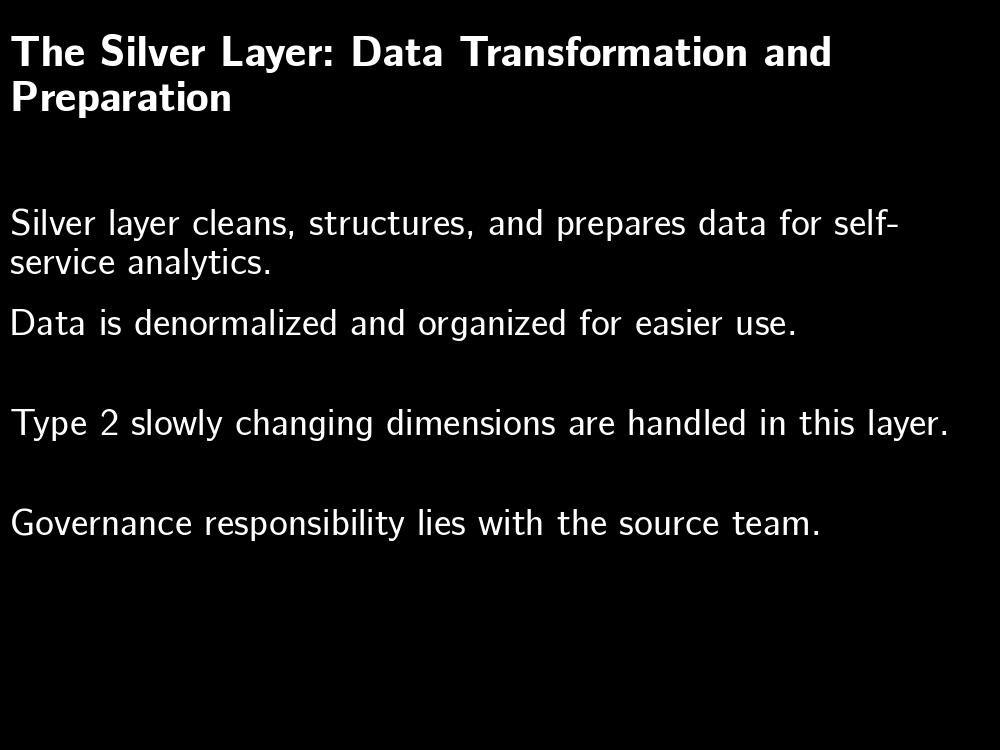

In [25]:
from IPython.display import Image
Image(filename='article_slides/slide_03.jpg') 

In [26]:
from moviepy.editor import ImageClip, AudioFileClip, concatenate_videoclips

In [27]:
import os
audio_files = sorted(os.listdir("article_audio"))
audio_files

['audio_00.mp3',
 'audio_01.mp3',
 'audio_02.mp3',
 'audio_03.mp3',
 'audio_04.mp3',
 'audio_05.mp3',
 'audio_06.mp3',
 'audio_07.mp3',
 'audio_08.mp3']

In [28]:
slide_files = sorted(os.listdir("article_slides"))
slide_files

['slide_00.jpg',
 'slide_01.jpg',
 'slide_02.jpg',
 'slide_03.jpg',
 'slide_04.jpg',
 'slide_05.jpg',
 'slide_06.jpg',
 'slide_07.jpg',
 'slide_08.jpg']

In [59]:
clips = []
for slide, audio in zip(slide_files, audio_files):
    audio_clip = AudioFileClip(f"article_audio/{audio}")
    slide_clip = ImageClip(f"article_slides/{slide}").set_duration(audio_clip.duration)
    slide_clip = slide_clip.set_audio(audio_clip)
    clips.append(slide_clip)
full_video = concatenate_videoclips(clips)

In [60]:
full_video.duration

269.35

In [ ]:
full_video.write_videofile("lecture.mp4", fps=24, codec="mpeg4", 
                           temp_audiofile='temp-audio.mp4', remove_temp=True)

In [62]:
!ls lecture.*

lecture.json  lecture.mp4  lecture.pptx  lecture.wav
